<a href="https://colab.research.google.com/github/cane11/PopV/blob/main/tabula_sapiens_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Tabula Sapiens as a reference for annotating new datasets

This notebook allows you to annotate your data with a number of annotation methods using the Tabula Sapiens dataset as the reference. 

Initial setup: 
1. Make sure GPU is enabled (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU)
2. We also highly recommend getting Colab PRO for access to an extended RAM session.


Integration Methods Provided:
- scVI [(Lopez et al. 2018)](https://www.nature.com/articles/s41592-018-0229-2)
- bbKNN [(Polański et al. 2020)](https://academic.oup.com/bioinformatics/article/36/3/964/5545955)
- Scanorama [(He et al. 2019)](https://www.nature.com/articles/s41587-019-0113-3)

Annotation Methods:
- KNN on integrated spaces
- scANVI [(Xu et al. 2021)](https://www.embopress.org/doi/full/10.15252/msb.20209620)
- onClass [(Wang et al. 2020)](https://www.biorxiv.org/content/10.1101/810234v2)
- Celltypist [(Dominguez Conde et al. 2022)](https://www.science.org/doi/10.1126/science.abl5197)
- SVM 
- RandomForest

To use the notebook, simply connect to your Google Drive account, set the necessary arguments, select your methods, and run all the code blocks!

**User action is only required in Steps 1-3.**

Last edited: 6/27/2021



## Step 1: Setup environment

We omit the output of those lines for readability.

In [1]:
ls

tabula_sapiens_tutorial.ipynb  tutorial.ipynb*


In [2]:
clone_github_repo = (
    True  # Set to True if running outside of already exisiting Github repository.
)
if clone_github_repo:
    !git clone https://github.com/czbiohub/PopV.git

fatal: destination path 'PopV' already exists and is not an empty directory.


In [ ]:
!pip install popv

# Restart the Runtime after installation (User Action Required)

Runtime -> "Restart runtime"

In [2]:
%%capture
import popv
import numpy as np
import scanpy as sc
import os

# Step 2: Load your data (User Action Required)
Here we provide three options to load your data:
1. Connect to Google Drive (highly recommended)
2. Download your data from the cloud and save into this session or on Google drive.
3. Upload your data manually into this session (files are not persistent and will be deleted when session is closed)

As an example, we use a subsampled version of the [Lung Cell Atlas](https://hlca.ds.czbiohub.org/) \[1] for our query data.

\[1] Travaglini, K. et al. A molecular cell atlas of the human lung from single-cell RNA sequencing. *Nature* **587**, 619–625(2020).

In [10]:
os.chdir("../../")

In [11]:
pwd

'/Users/can/Documents/new_popv2/PopV'

In [12]:
output_folder = "tmp_testing"
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [13]:
input_file = {
    "source": "wget",
    "path": "tmp_testing/LCA.h5ad",
    "link": "https://www.dropbox.com/s/mrf8y7emfupo4he/LCA.h5ad?dl=1",
}

if input_file["source"] == "gdrive":
    # OPTION 1: Connect to Google Drive
    # This is the recomended method especially for large datasets
    from google.colab import drive

    drive.mount("/content/drive")
    query_adata = sc.read(input_file["path"])
elif input_file["source"] == "local":
    # OPTION 2: Uploading data manually
    # Click the folder icon on the left navigation bar, and select the upload icon
    # Note: Manually uploaded data is automatically deleted when the colab session ends
    # This is not recommended if your dataset is very large
    query_adata = sc.read(input_file["path"])
else:
    # OPTION 3: Downloading from the cloud (Dropbox, AWS, Google Drive, etc)
    # Google Colab supports wget, curl, and gdown commands
    # It is recommended to download the data into Google Drive and read from there.
    # This way your data will be persistent.
    print("downloading")
    try:
        !wget -O {input_file['path']} {input_file['link']}
        query_adata = sc.read(input_file["path"])
    except:
        raise Exception(
            f"Default download failed with wget. Use custom downloader or check provided link "
            + input_file["link"]
        )

query_adata.obs_names_make_unique()
#Downsample to reduce RAM usage. Not necessary with Google Colab Pro.
sc.pp.subsample(query_adata, 0.2)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'tmp_testing/LCA.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Step 3 (User Action Required): Setting Up Annotation Parameters 

Here is where you set the parameters for the automated annotation.

Arguments:
- **tissue:** Tabula Sapiens tissue to annotate your data with. Available tissues: ["Bladder", "Blood", "Bone_Marrow", "Kidney", "Large_Intestine", "Lung","Lymph_Node", "Pancreas", "Small_Intestine", "Spleen", "Thymus","Trachea", "Vasculature"]
- **save_location:** location to save results to. By default will save to a folder named `annotation_results`. It is highly recommended you provide a Google Drive folder here.
- **query_batch_key:** key in `query_adata.obs` for batch correction. Set to None for no batch correction. 
- **algorithms:** these are the methods to run. By default, will run all methods.
Options: ["knn_on_scvi_pred", "scanvi_pred", "knn_on_bbknn_pred", "svm_pred", "rf_pred", "onclass_pred", "knn_on_scanorama_pred",


Lesser used parameters
- **query_labels_key**: scANVI has the option to use labeled cells in the query dataset during training. To use some prelabeled cells from the query dataset, set `query_labels_key` to the corresponding key in `query_adata.obs`
- **unknown_celltype_label**: If `query_labels_key` is not None, will treat everything not labeled `unknown_celltype_label` as a labeled cell

In [7]:
""" 
tissue options: 
['Bladder','Blood','Bone_Marrow','Fat',
'Heart','Kidney','Large_Intestine','Liver',
'Lung','Lymph_Node','Mammary','Muscle',
'Pancreas','Prostate','Salivary Gland',
'Skin','Small_Intestine','Spleen',
'Thymus','Trachea','Vasculature']
"""
tissue = "Lung"

query_batch_key = "donor_method"
algorithms = None

# Lesser used parameters
query_labels_key = None
unknown_celltype_label = "unknown"

# Step 4: Downloading Reference Data and Pretrained Models
No more user input required! Just run all the following code blocks.

**NOTE: PopV has only been evaluated with the Lung/Thymus/Lymph_Node as a reference dataset. Different tissues have different annotation quality and the Tabula sapiens community is currently actively improving the annotation quality. We strongly expect improvement of cell annotation when the updated annotation is released. Upon release the Zenodo repository will be updated.**

In [8]:
import requests

res = requests.get("https://zenodo.org/api/records/7587774")
tissue_download_path = {
    ind["key"][3:-14]: ind["links"]["self"] for ind in res.json()["files"]
}

In [9]:
res = requests.get("https://zenodo.org/api/records/7580707")
pretrained_models_download_path = {
    ind["key"][18:-10]: ind["links"]["self"] for ind in res.json()["files"]
}

In [10]:
output_folder = "tmp"
refdata_url = tissue_download_path[tissue]
if not os.path.exists(output_folder):
    os.mkdir(output_folder)
output_fn = f"{output_folder}/TS_{tissue}.h5ad"
if not os.path.exists(output_fn):
    !wget -O $output_fn $refdata_url

In [11]:
!echo $output_model_tar_fn $model_url

In [12]:
model_url = pretrained_models_download_path[tissue]
output_model_tar_fn = f"{output_folder}/pretrained_model_{tissue}.tar.gz"
output_model_fn = f"{output_folder}/pretrained_model_{tissue}"
if not os.path.exists(output_model_fn):
    os.mkdir(output_model_fn)
if not os.path.exists(output_model_tar_fn):
    !wget -O $output_model_tar_fn $model_url
    !tar -xzf $output_model_tar_fn -C $output_model_fn

In [13]:
# read in the reference dataset
ref_adata = sc.read_h5ad(output_fn)
sc.pp.subsample(ref_adata, 0.05)

### Setup reference data

In [14]:
# Following parameters are specific to Tabula Sapiens dataset and contain the annotated cell-type and the batch_key that are corrected for during model training.
ref_labels_key = "cell_ontology_class"
ref_batch_key = "donor_assay"

In [15]:
min_celltype_size = np.min(ref_adata.obs.groupby(ref_labels_key).size())
n_samples_per_label = np.max((min_celltype_size, 500))

### Preprocess query with ref dataset


In [16]:
ls

CODE_OF_CONDUCT.md             pyproject.toml
LICENSE                        setup.py
README.md                      tabula_sapiens_tutorial.ipynb
codecov.yml                    tests/
dataset/                       tmp/
ontology/                      tmp_testing/
poetry.lock                    tutorial.ipynb*
popv/


In [17]:
from popv.preprocessing import Process_Query

adata = Process_Query(
    query_adata,
    ref_adata,
    query_labels_key=query_labels_key,
    query_batch_key=query_batch_key,
    ref_labels_key=ref_labels_key,
    ref_batch_key=ref_batch_key,
    unknown_celltype_label=unknown_celltype_label,
    save_path_trained_models=output_model_fn,
    cl_obo_folder="./PopV/resources/ontology/",
    prediction_mode="inference",  # 'fast' mode gives fast results (does not include BBKNN and Scanorama and makes more inaccurate predictions)
    n_samples_per_label=n_samples_per_label,
    accelerator="cuda",
    compute_embedding=True,
    hvg=None,
).adata

In [19]:
adata

AnnData object with n_obs × n_vars = 16797 × 4000
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay', '_batch_annotation', '_labels_annotation', '_ref_subsample', 'method', 'donor', 'cell_ontology_type', 'donor_method', 'cell_ontology_id', '_dataset', 'n_counts'
    var: 'mean', 'std'
    uns: 'Filtered_cells', 'log1p', 'unknown_celltype_label', '_pretrained_scvi_path', '_save_path_trained_models', '_prediction_mode', '_cl_obo_file', '_cl_ontology_file', '_nlp_emb_file', '_accelerator', '_devices', '_compute_embedding', '_return_probabilities', 'prediction_keys'
    obsm: 'X_pca', 'X_scvi', 'X_scvi_umap', 'X_umap'
    layers: 'scvi_counts', 'scaled_counts'

In [25]:
from popv.annotation import annotate_data

annotate_data(adata, save_path=f"{output_folder}/popv_output")

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).
Found 4000 genes among all datasets
[[0.         0.11688312 0.53353973 0.00605144 0.79050568 0.01146789
  0.10222222 0.06041335 0.06818182 0.06571087 0.02083333]
 [0.         0.         0.16363636 0.60060514 0.13376623 0.83256881
  0.03111111 0.04935065 0.36363636 0.05714286 0.5       ]
 [0.         0.         0.         0.33888048 0.51015597 0.01376147
  0.40888889 0.20190779 0.25       0.16367981 0.125     ]
 [0.         0.         0.         0.         0.06202723 0.71788991
  0.01777778 0.01059002 0.38636364 0.0083632  0.29166667]
 [0.         0.         0.         0.         0.         0.31880734
  0.28888889 0.42289348 0.68181818 0.50298686 0.35416667]
 [0.         0.         0.         0.         0.         0.
  0.01777778 0.0206422  0.65909091 0.06880734 0.58333333]
 [0.         0.         0.         0.         0.  

In [26]:
adata.uns["_save_path_trained_models"]

'tmp/pretrained_model_Lung/'

In [27]:
# Optional: save the full anndata will all objects
# adata.write(f'{output_folder}/query_and_reference_popv.h5ad')

In [28]:
adata

AnnData object with n_obs × n_vars = 16797 × 4000
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay', '_batch_annotation', '_labels_annotation', '_ref_subsample', 'method', 'donor', 'cell_ontology_type', 'donor_method', 'cell_ontology_id', '_dataset', 'n_counts', 'popv_svm_prediction', 'popv_svm_prediction_probabilities', 'popv_majority_vote_prediction', 'popv_majority_vote_score', 'popv_prediction', 'popv_prediction_score', 'popv_prediction_depth', 'popv_prediction_onclass_relative_depth', 'popv_parent', 'popv_celltypist_prediction', 'popv_celltypist_prediction_probabilities', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_bbknn_prediction_probabilities', 'popv_knn_on_harmony_prediction', 'popv_knn_on_harmony_prediction_probabilities', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scanoram

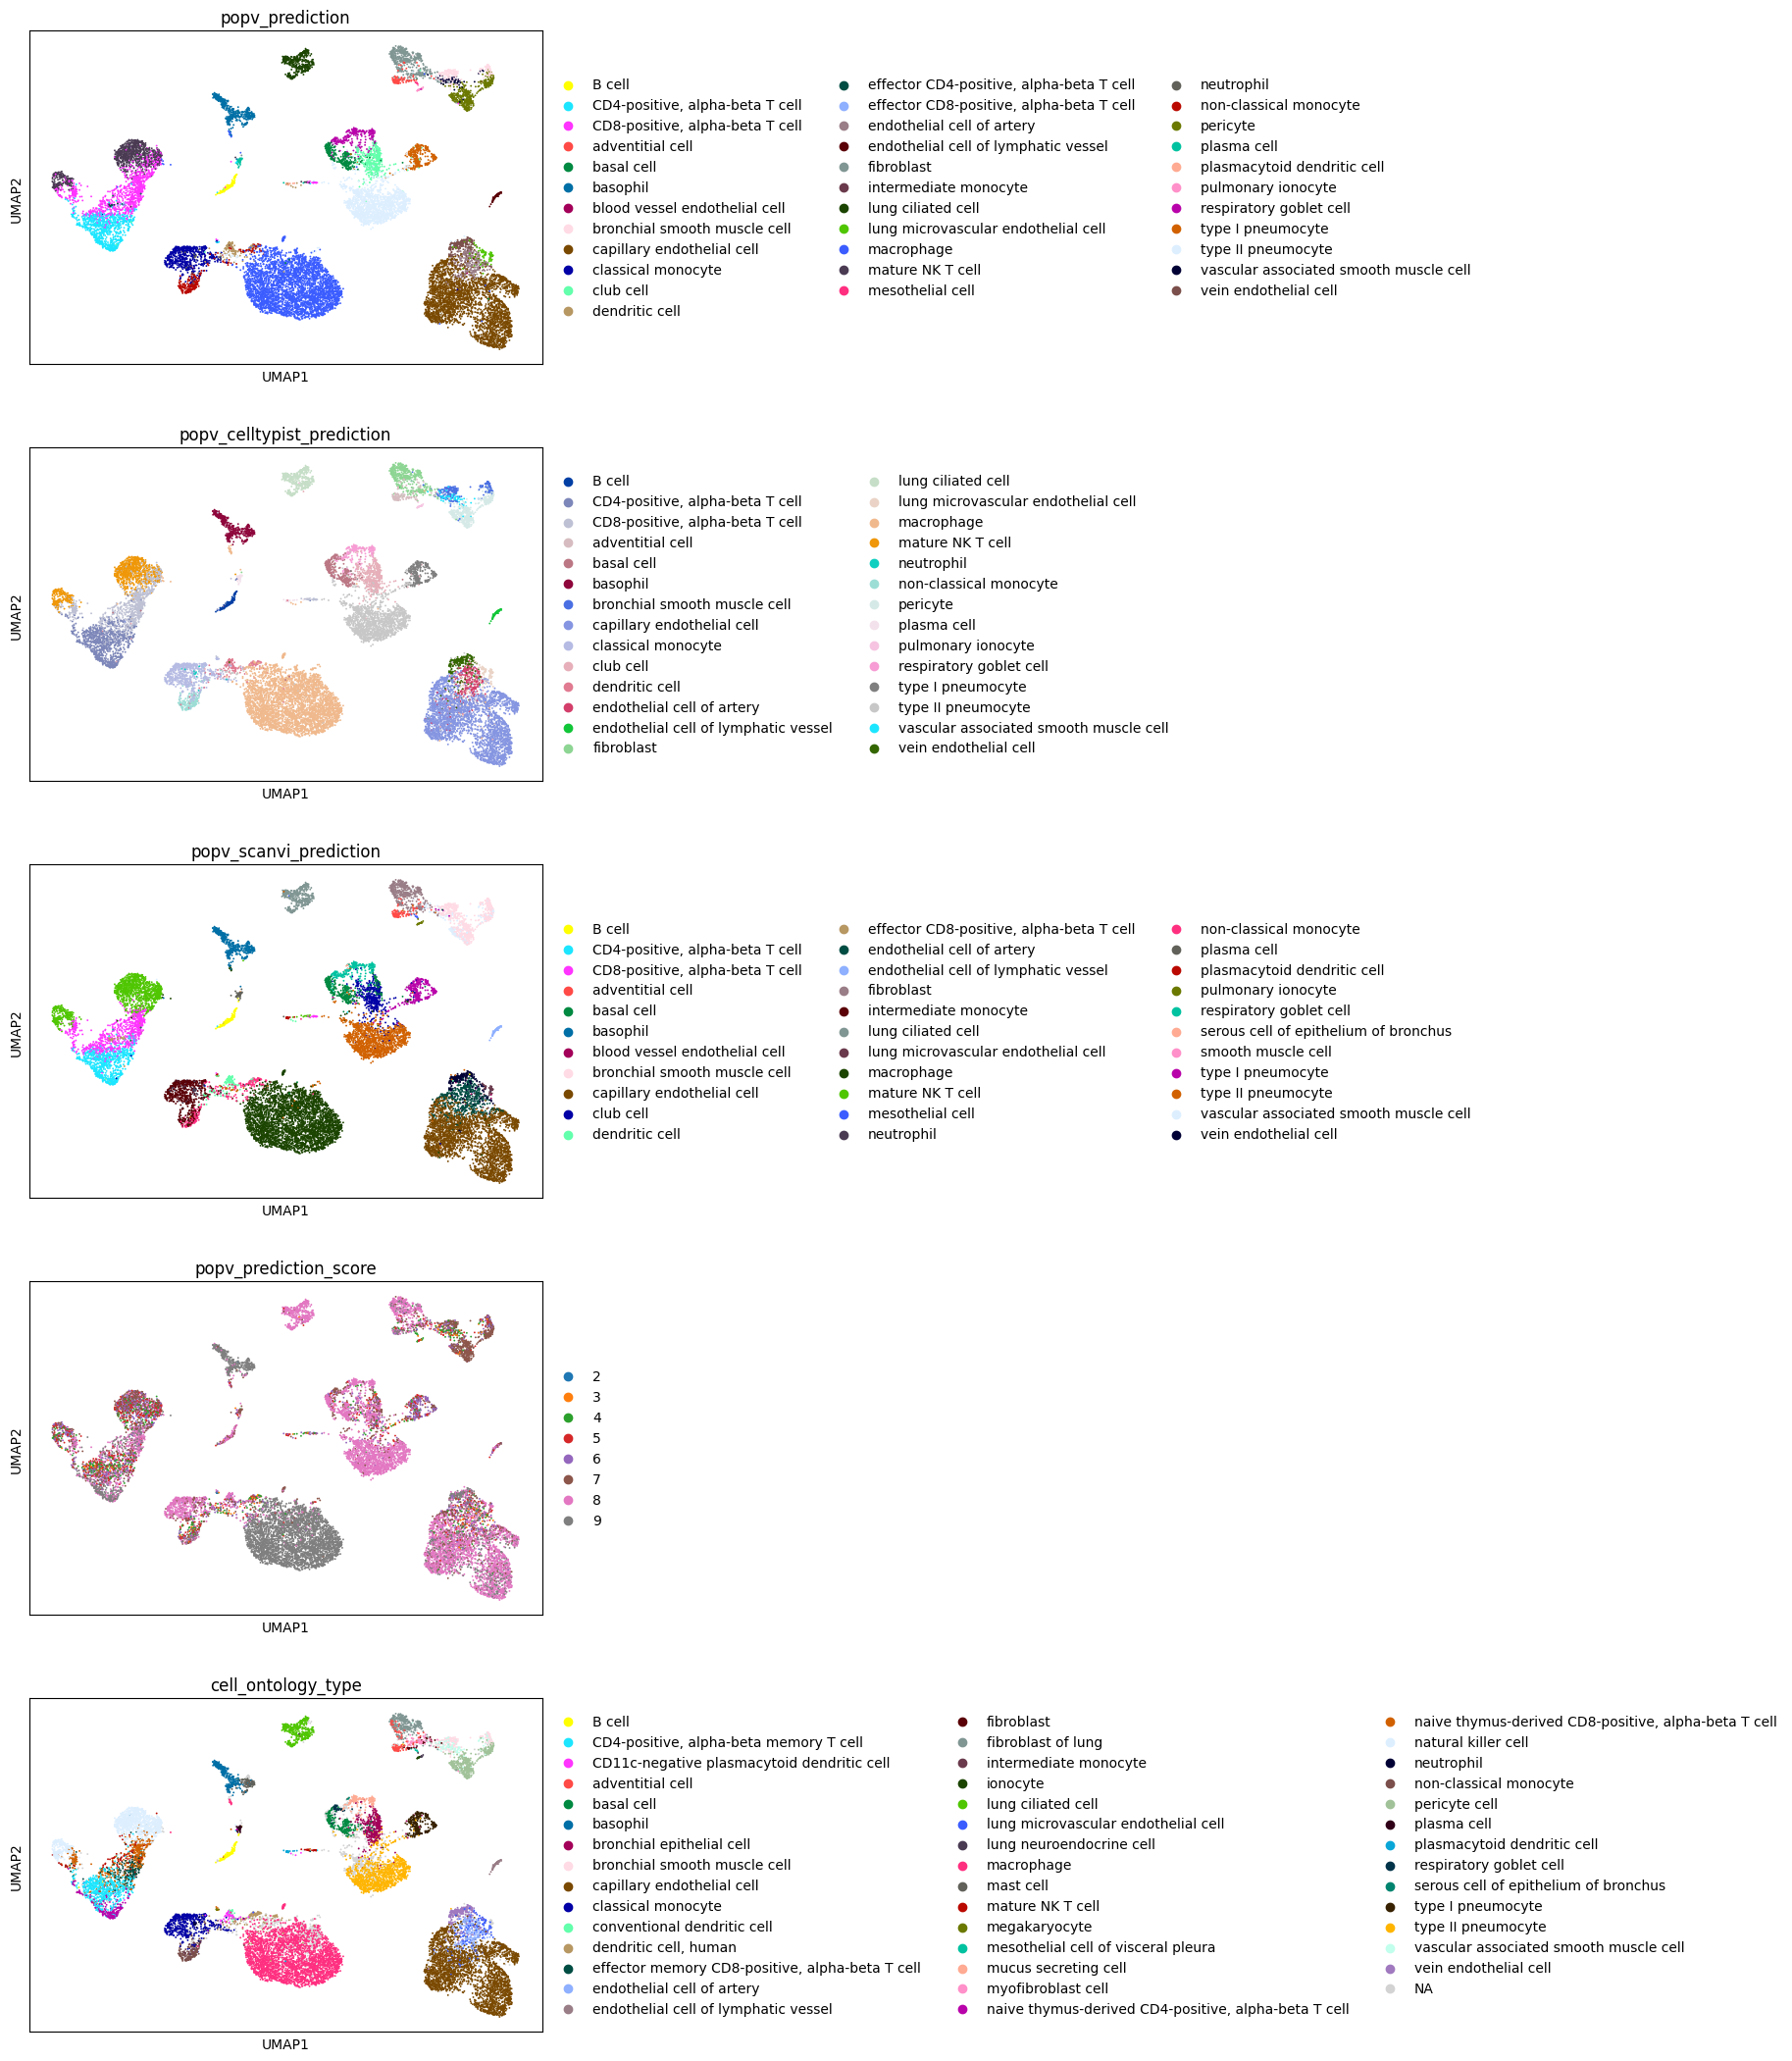

In [29]:
adata.obsm["X_umap"] = adata.obsm["X_scvi_umap_popv"]

sc.pl.umap(
    adata,
    color=[
        "popv_prediction",
        "popv_celltypist_prediction",
        "popv_scanvi_prediction",
        "popv_prediction_score",
        "cell_ontology_type",
    ],
    ncols=1,
)

# Step 6: Summary Statistics

In [30]:
adata

AnnData object with n_obs × n_vars = 16797 × 4000
    obs: 'tissue_in_publication', 'donor_id', 'free_annotation', 'compartment', 'cell_type_ontology_term_id', 'cell_type', 'assay', 'sex', 'tissue', 'cell_ontology_class', 'cell_ontology_class_tissue', 'donor_tissue', 'assay_correct', 'donor_assay', '_batch_annotation', '_labels_annotation', '_ref_subsample', 'method', 'donor', 'cell_ontology_type', 'donor_method', 'cell_ontology_id', '_dataset', 'n_counts', 'popv_svm_prediction', 'popv_svm_prediction_probabilities', 'popv_majority_vote_prediction', 'popv_majority_vote_score', 'popv_prediction', 'popv_prediction_score', 'popv_prediction_depth', 'popv_prediction_onclass_relative_depth', 'popv_parent', 'popv_celltypist_prediction', 'popv_celltypist_prediction_probabilities', 'popv_knn_on_bbknn_prediction', 'popv_knn_on_bbknn_prediction_probabilities', 'popv_knn_on_harmony_prediction', 'popv_knn_on_harmony_prediction_probabilities', 'popv_knn_on_scanorama_prediction', 'popv_knn_on_scanoram

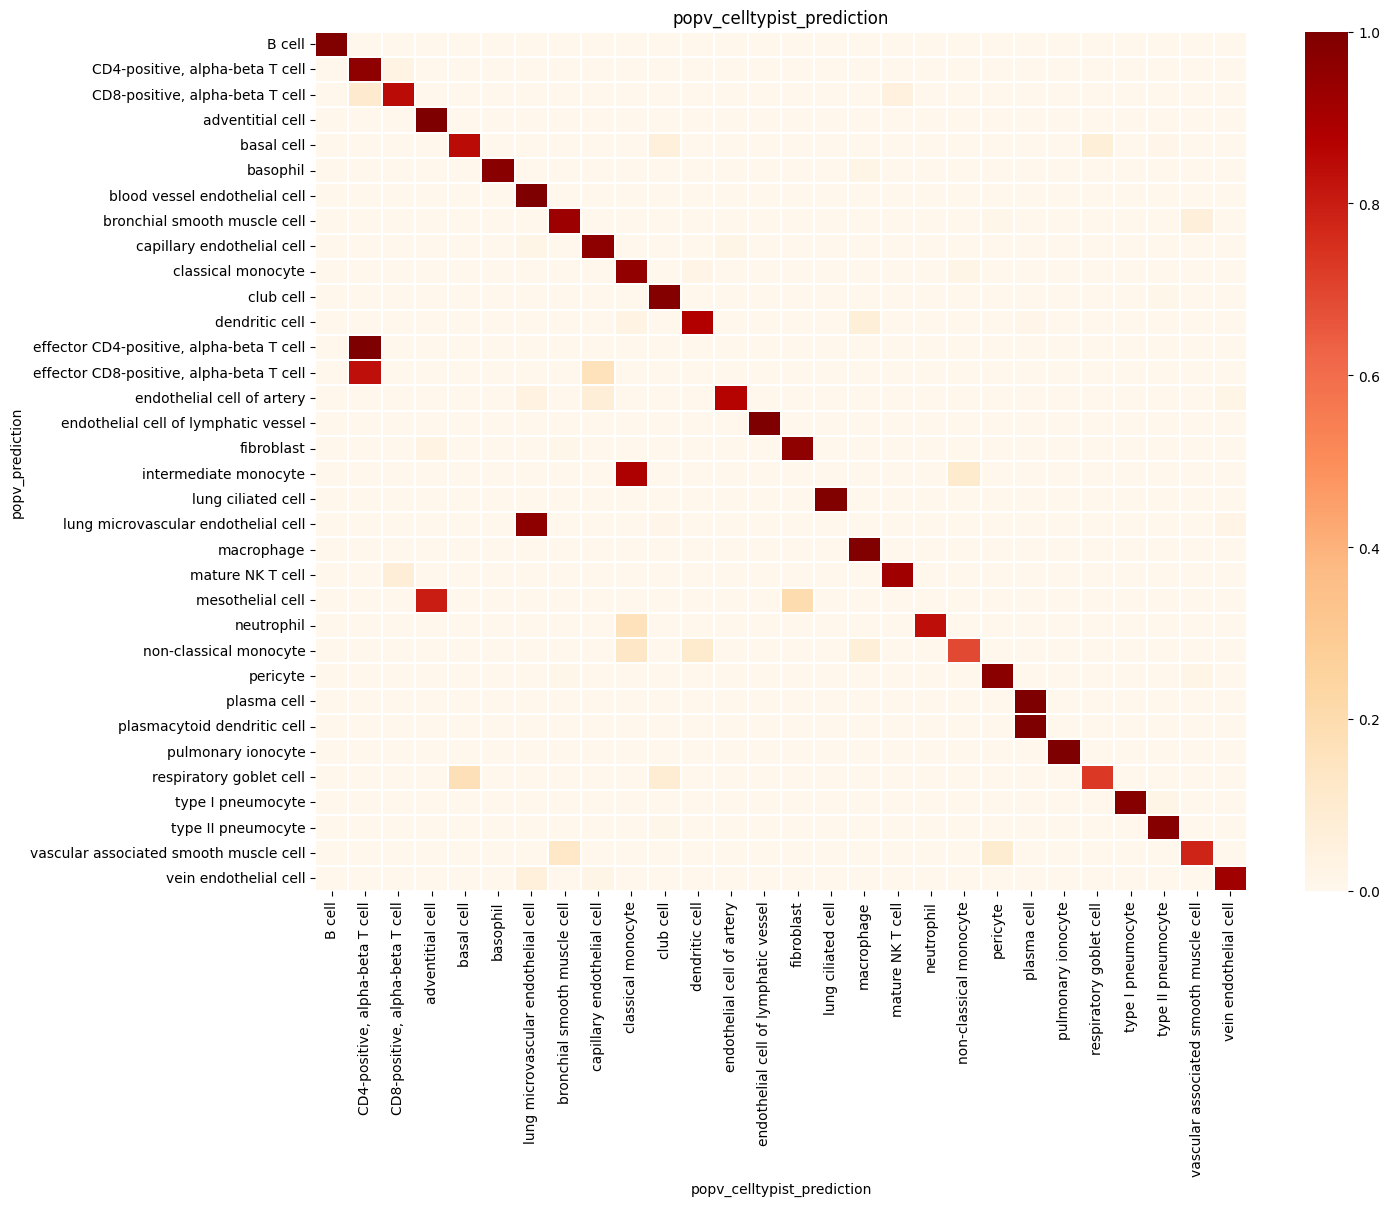

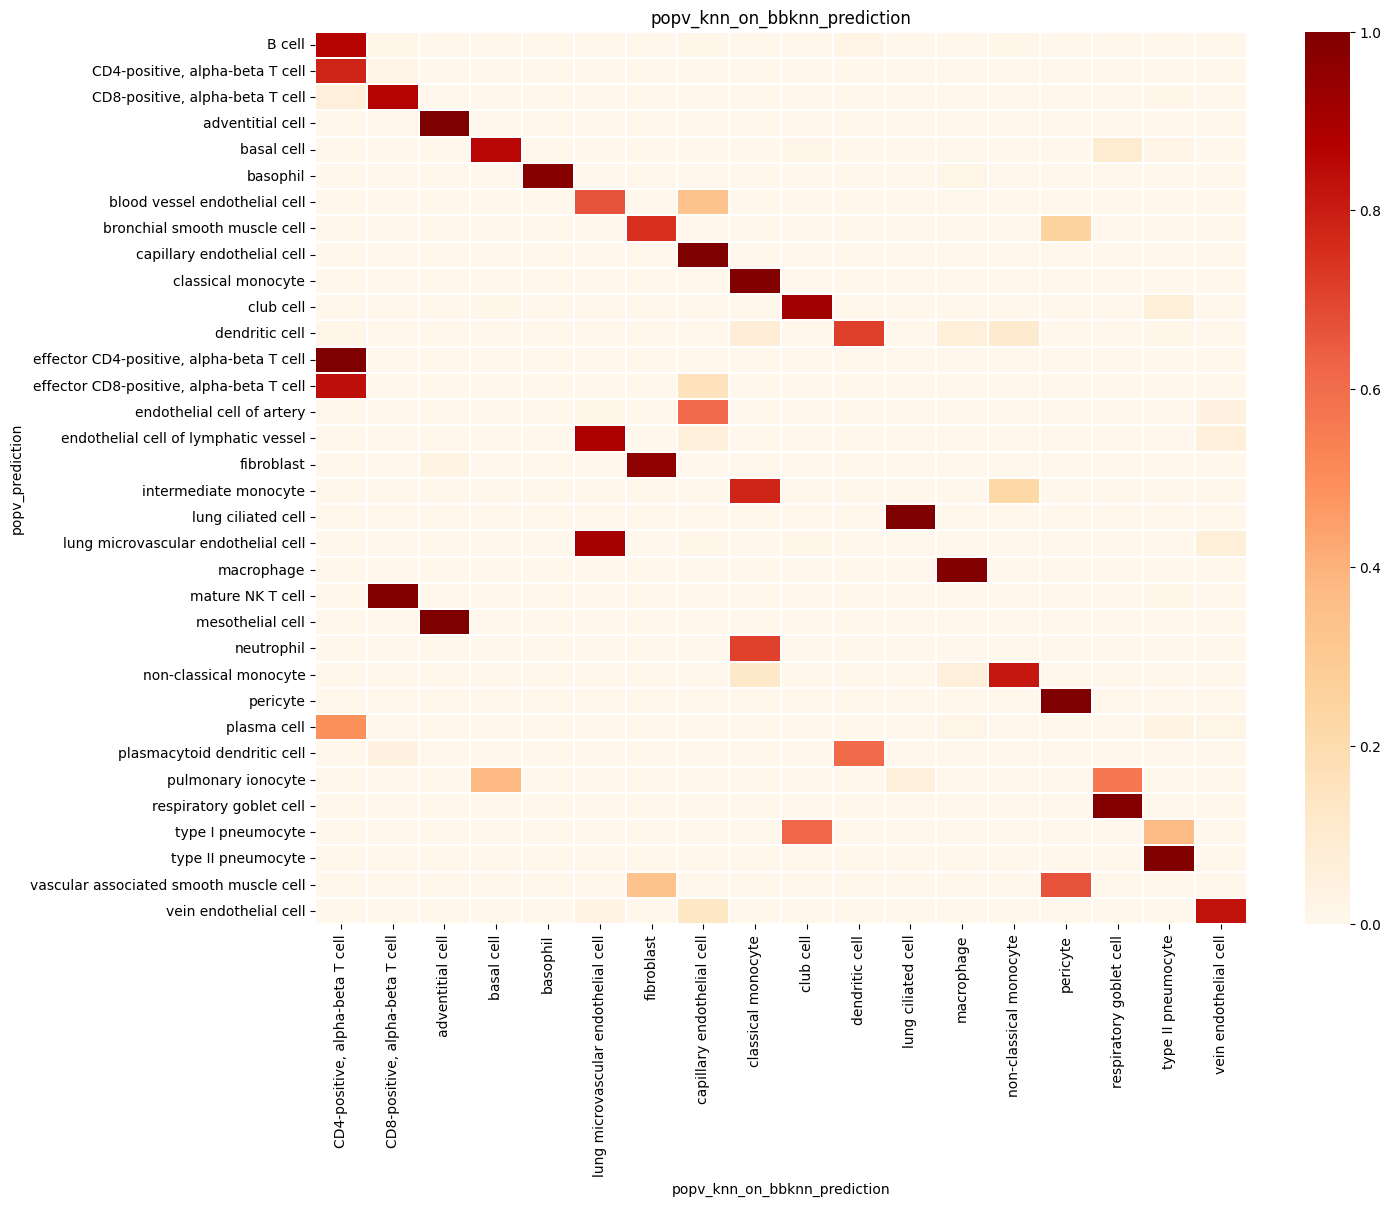

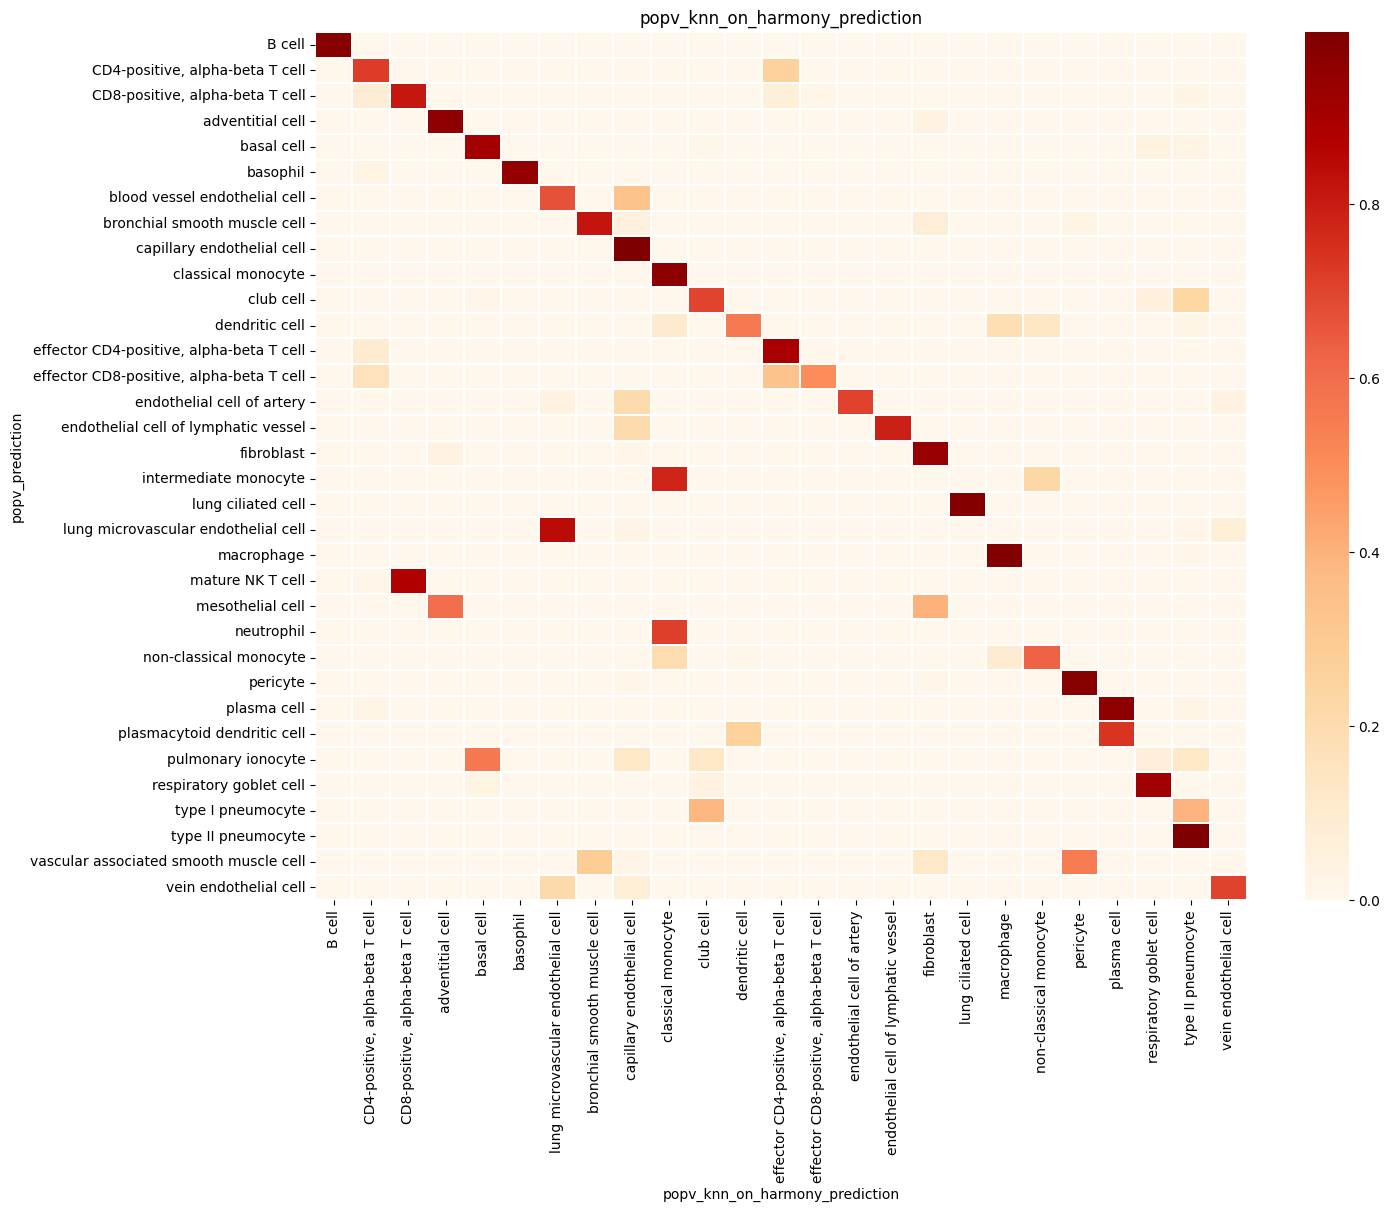

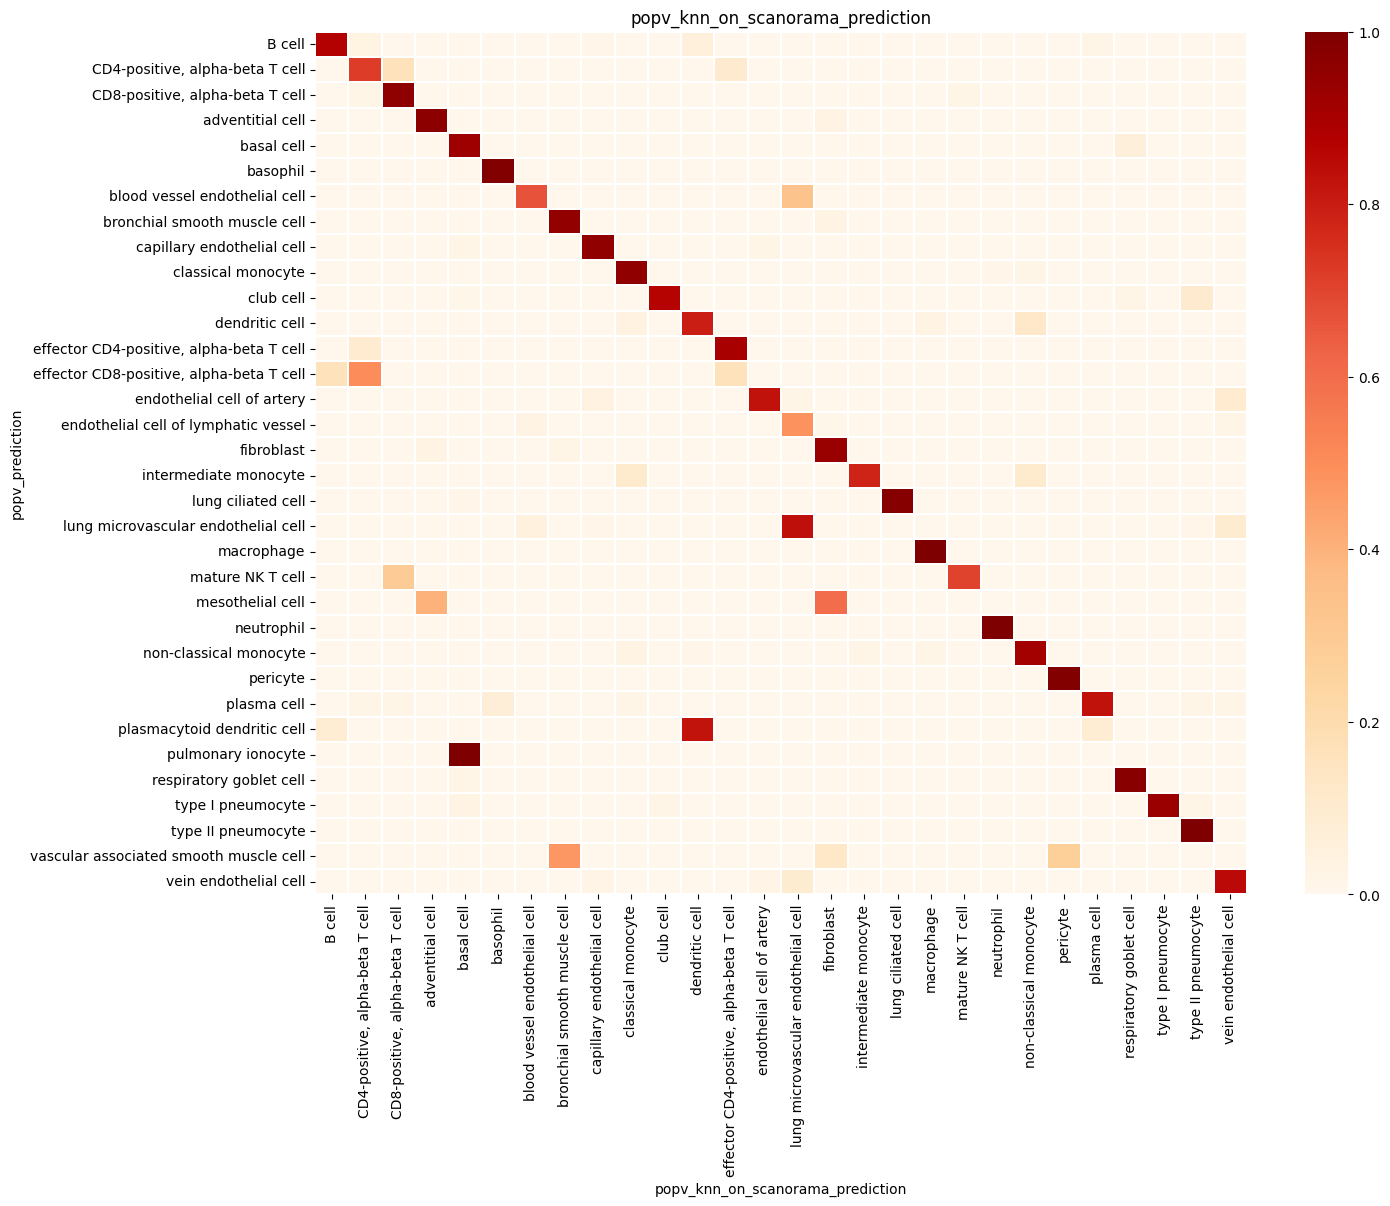

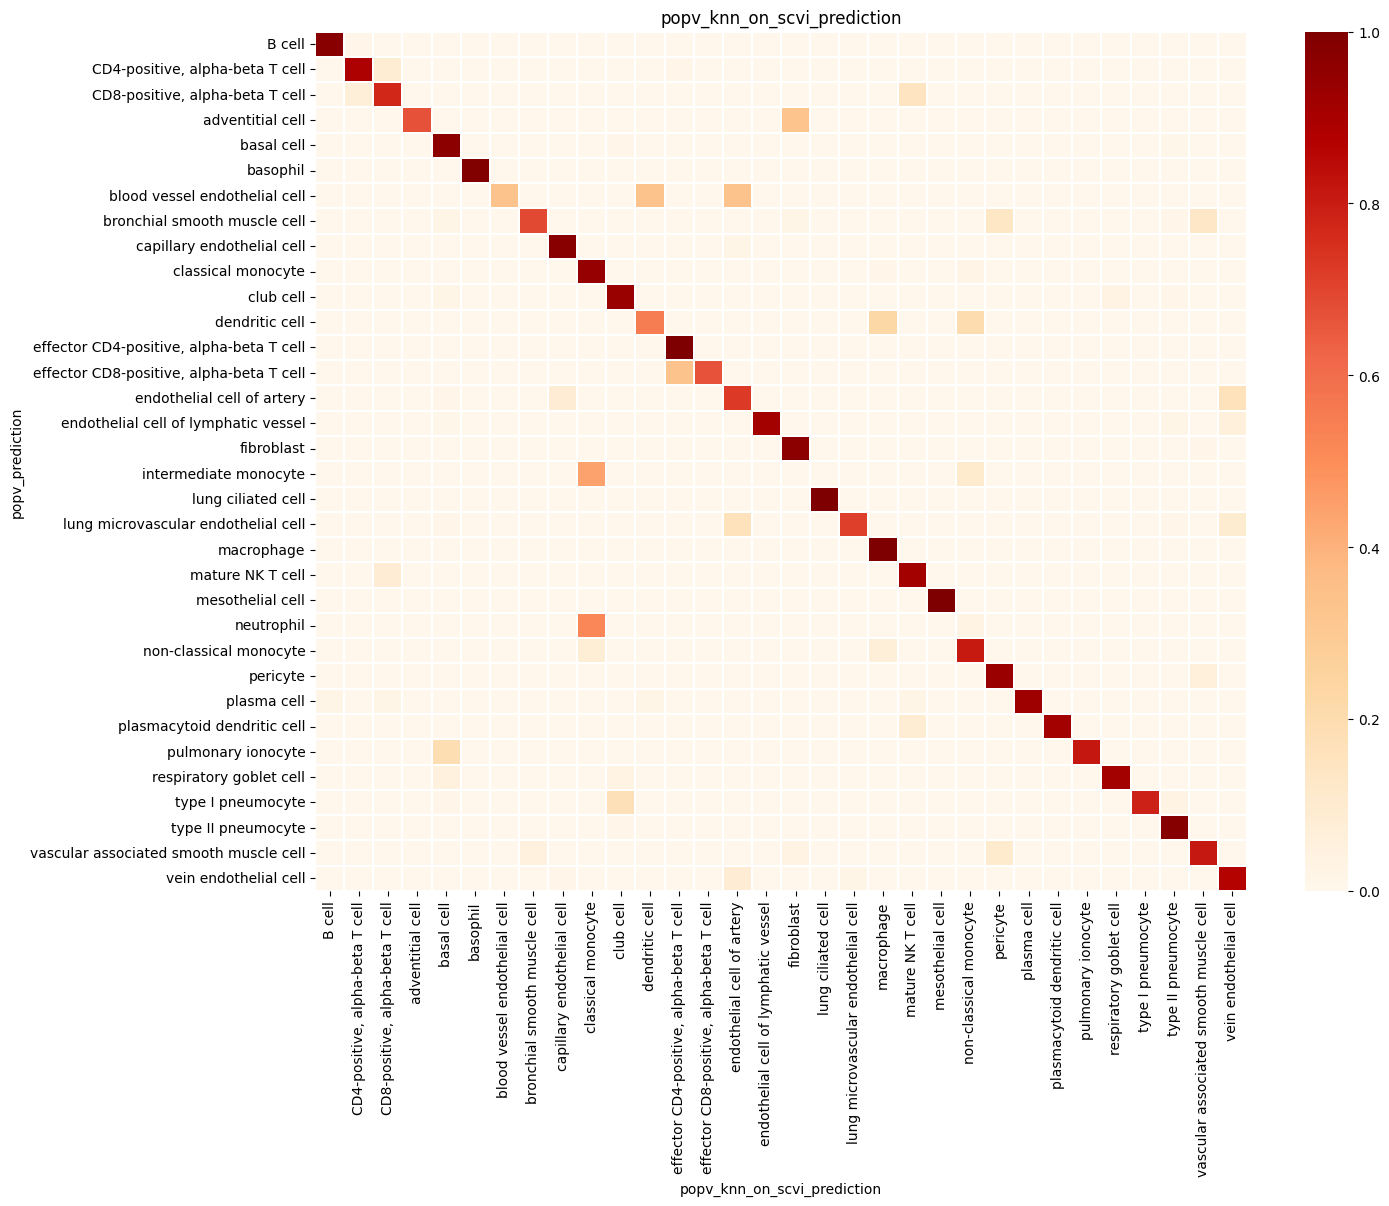

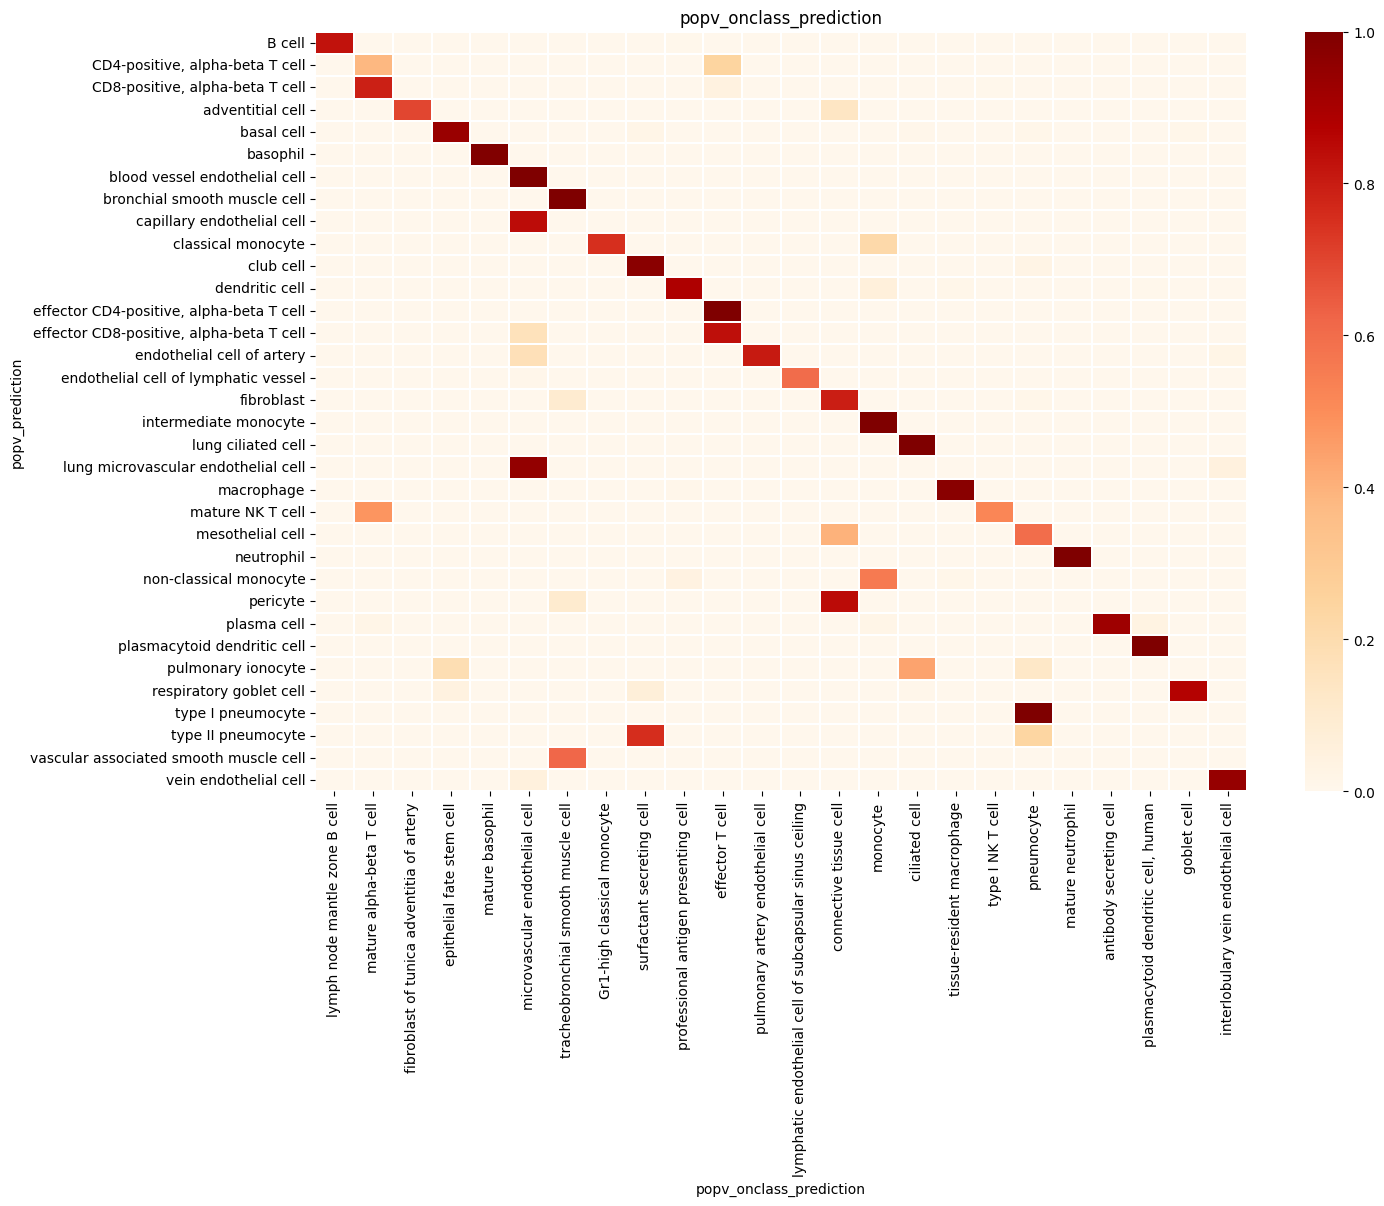

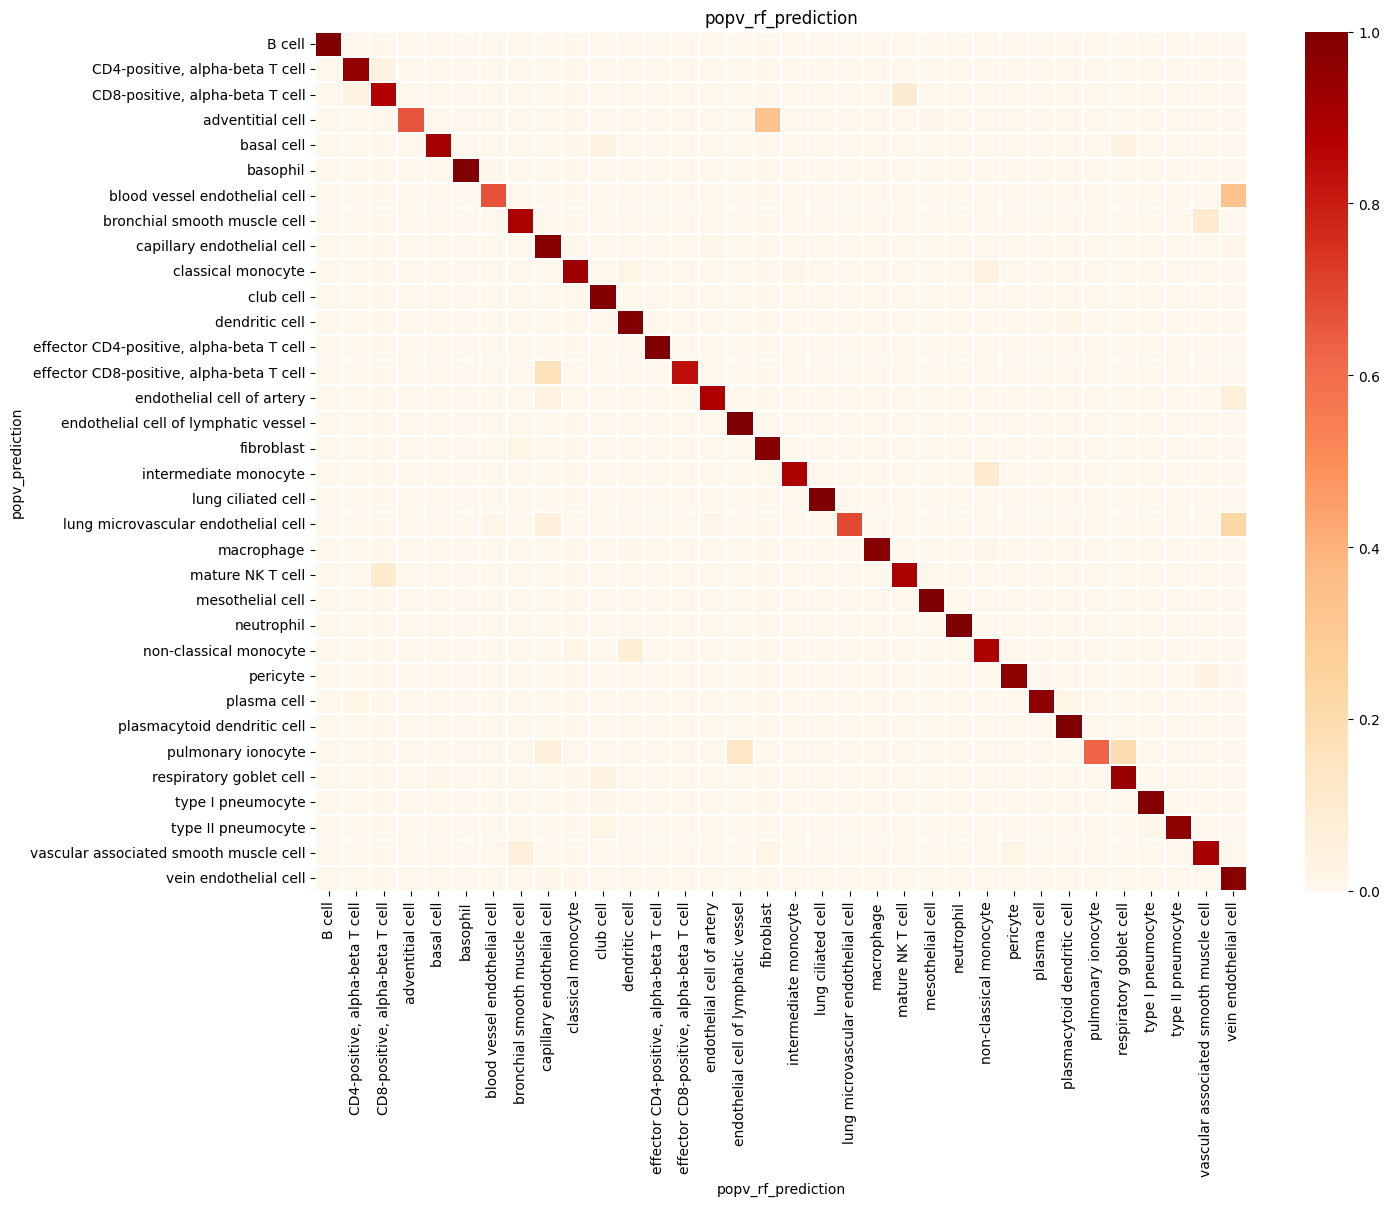

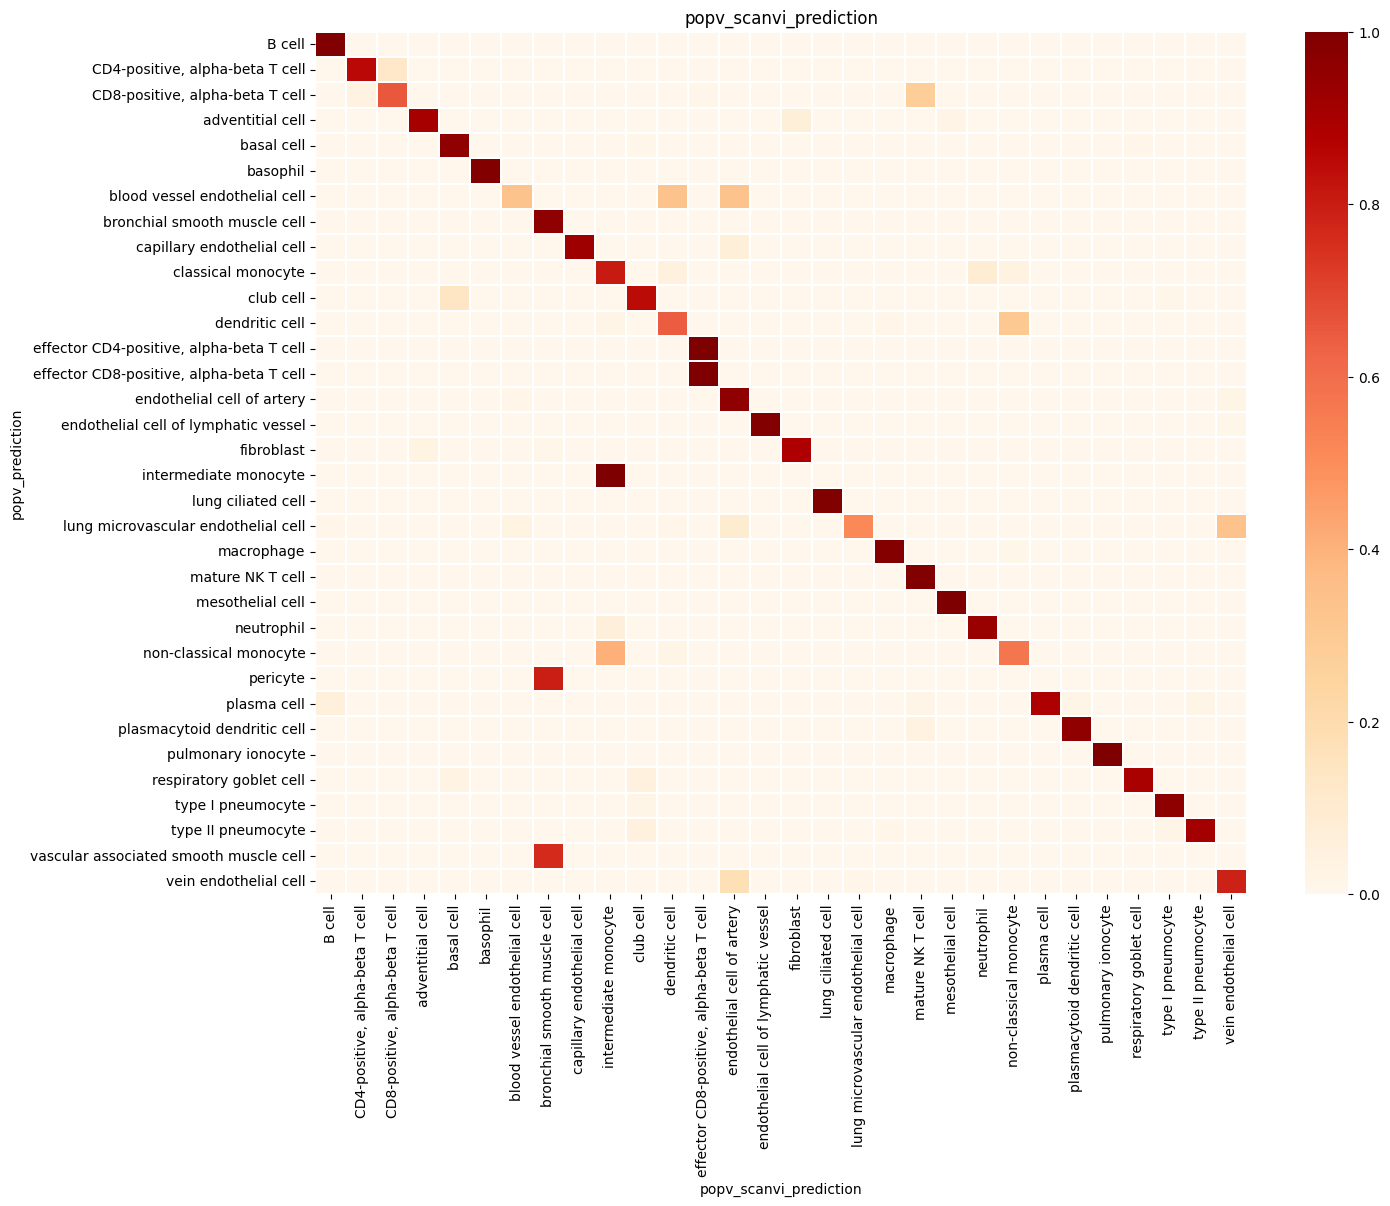

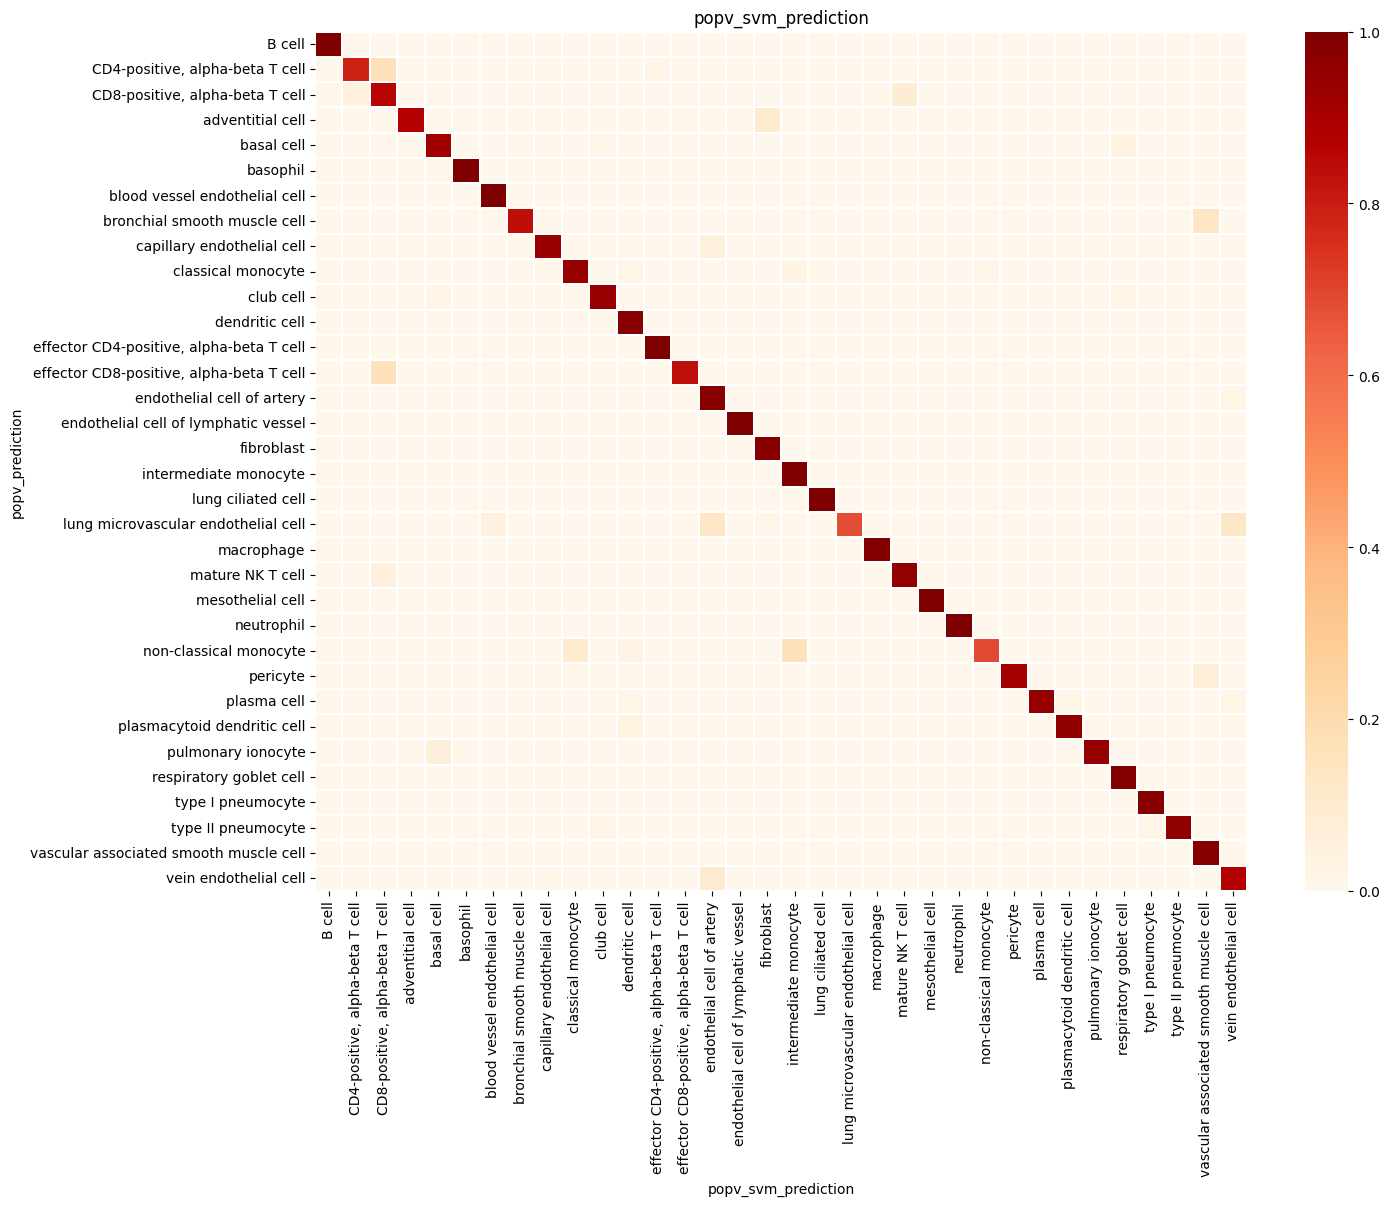

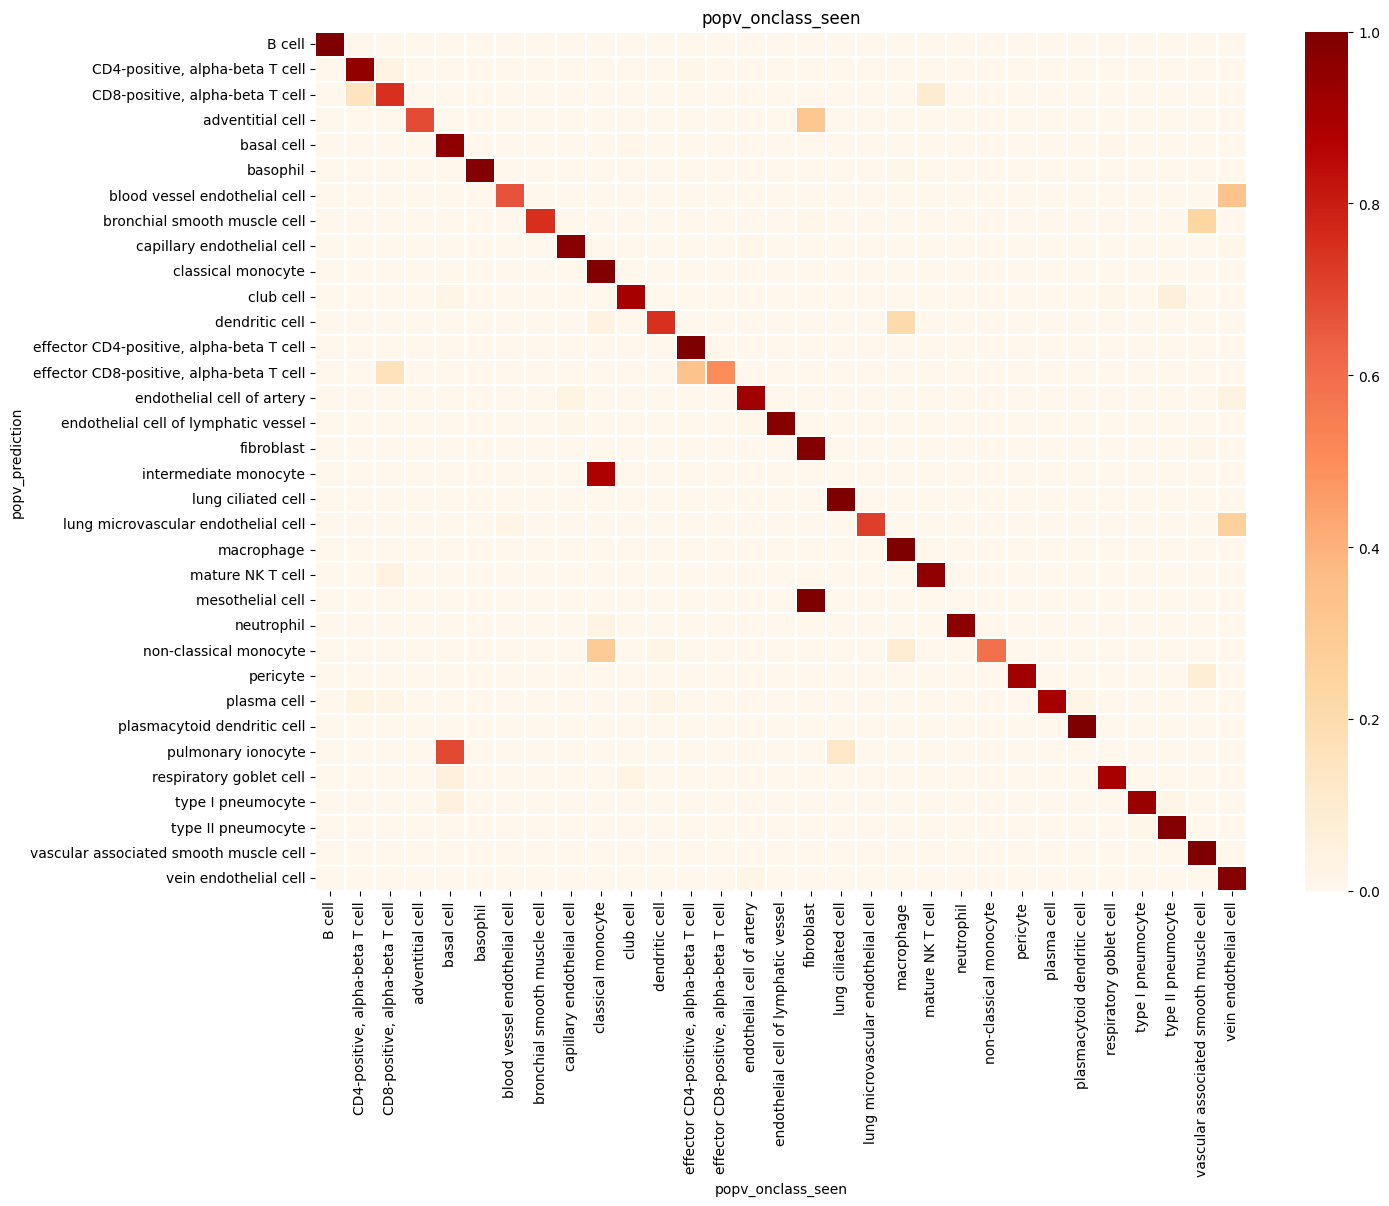

In [31]:
popv.visualization.make_agreement_plots(
    adata,
    prediction_keys=adata.uns["prediction_keys"] + ["popv_onclass_seen"],
    save_folder=output_folder,
)

<Axes: title={'center': 'PopV Prediction Score'}, xlabel='Score', ylabel='Frequency'>

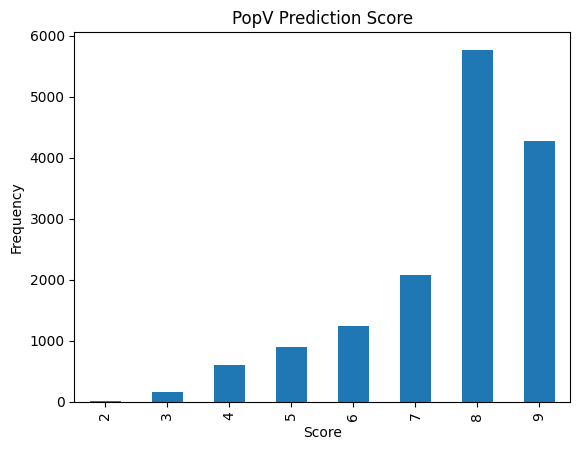

In [32]:
popv.visualization.prediction_score_bar_plot(
    adata, popv_prediction_score="popv_prediction_score"
)

<Axes: ylabel='Mean Agreement'>

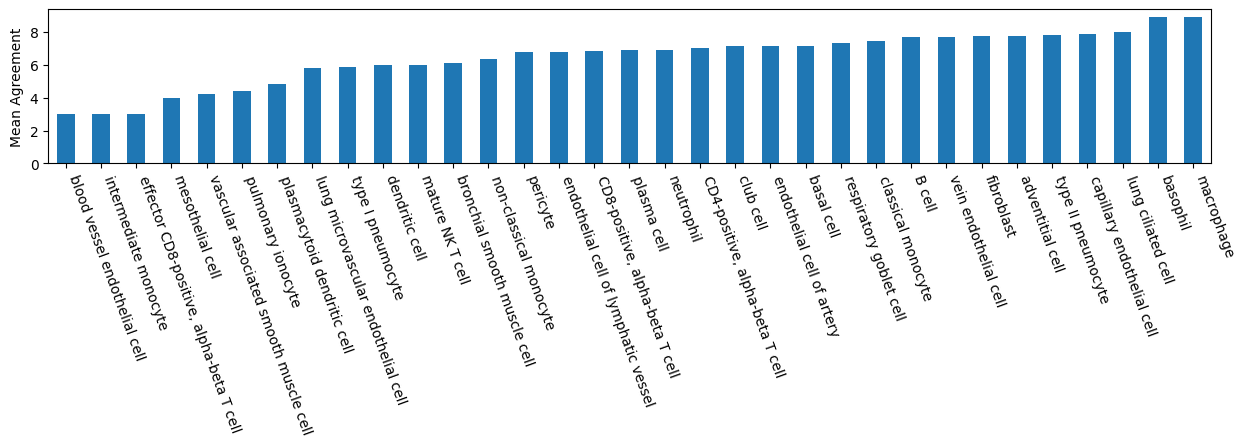

In [33]:
popv.visualization.agreement_score_bar_plot(adata)

### Cell type proportion plot

<Axes: ylabel='log Celltype Abundance'>

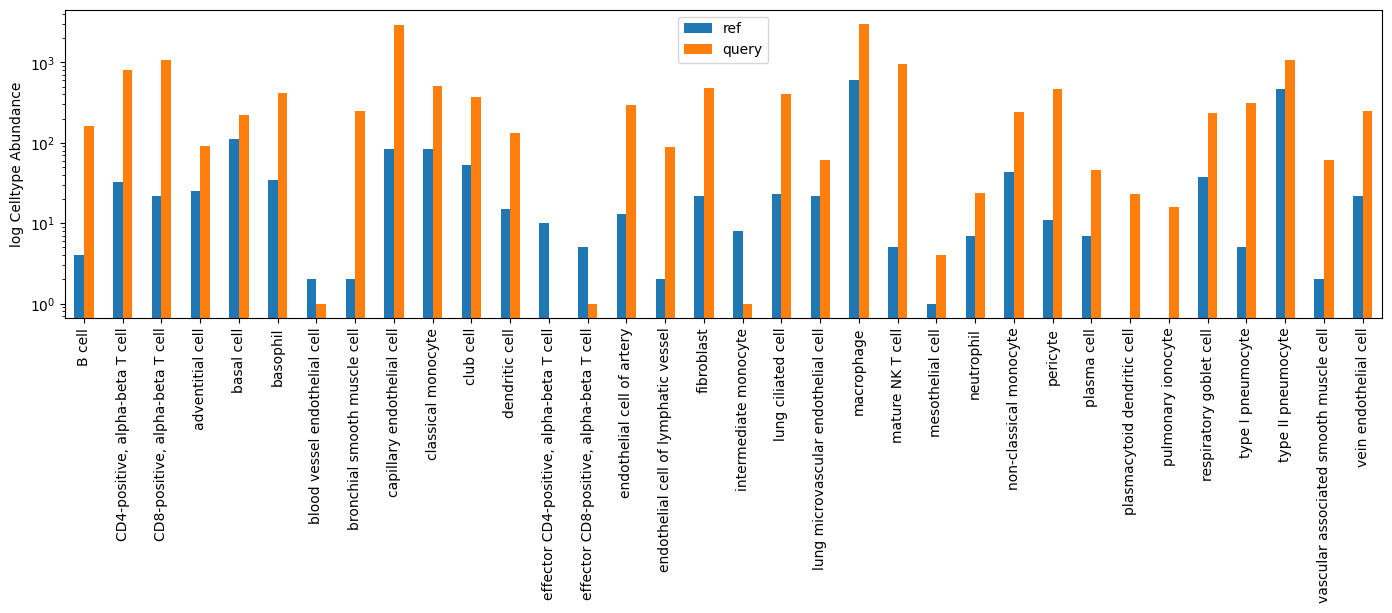

In [34]:
popv.visualization.celltype_ratio_bar_plot(adata)